In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from football_sim import *
plt.rcParams['figure.figsize']=[32,18]

In [2]:
urls = {'EN': 'http://www.football-data.co.uk/mmz4281/1718/E0.csv',
                          'ES': 'http://www.football-data.co.uk/mmz4281/1718/SP1.csv',
                          'IT': 'http://www.football-data.co.uk/mmz4281/1718/I1.csv',
                          'FR': 'http://www.football-data.co.uk/mmz4281/1718/F1.csv',
                          'DE': 'http://www.football-data.co.uk/mmz4281/1718/D1.csv',
                          'NL': 'http://www.football-data.co.uk/mmz4281/1718/N1.csv'
                          }
urls = {'EN': 'http://www.football-data.co.uk/mmz4281/1718/E0.csv',
                          'ES': 'http://www.football-data.co.uk/mmz4281/1718/SP1.csv'}

In [3]:
all_data=get_data(urls)

In [4]:
teams = create_teams(all_data)

In [5]:
teams=calibrate(teams,all_data)

In [6]:
EnglishTeams={x:teams[x] for x in teams if teams[x].country=='EN'}
PremierLeague=Season(EnglishTeams)
PremierLeague.process_current_results(all_data['EN'])
PremierLeague.simulate_season(n_scenarios=100000)

In [7]:
PremierLeague.season_report()

simulation not yet processed, processing


,Points (mean),Points (low),Points (high),Win,CL,Off,Deff,Degr
Man City,98.0,90.0,105.0,99.93,100.00,2.27,0.19,0.00
Man United,79.6,71.0,87.0,0.06,93.47,1.27,0.14,0.00
Liverpool,78.1,70.0,85.0,0.01,90.56,1.69,0.28,0.00
Chelsea,74.0,66.0,82.0,0.00,54.37,1.13,0.19,0.00
Tottenham,73.7,66.0,81.0,0.00,57.19,1.37,0.20,0.00
Arsenal,66.2,58.0,74.0,0.00,4.40,1.35,0.58,0.00
Burnley,54.8,47.0,63.0,0.00,0.00,0.34,0.16,0.00
Leicester,53.3,45.0,62.0,0.00,0.00,0.87,0.57,0.00
Bournemouth,45.5,37.0,54.0,0.00,0.00,0.62,0.73,0.39
Everton,44.4,36.0,53.0,0.00,0.00,0.48,0.92,1.23


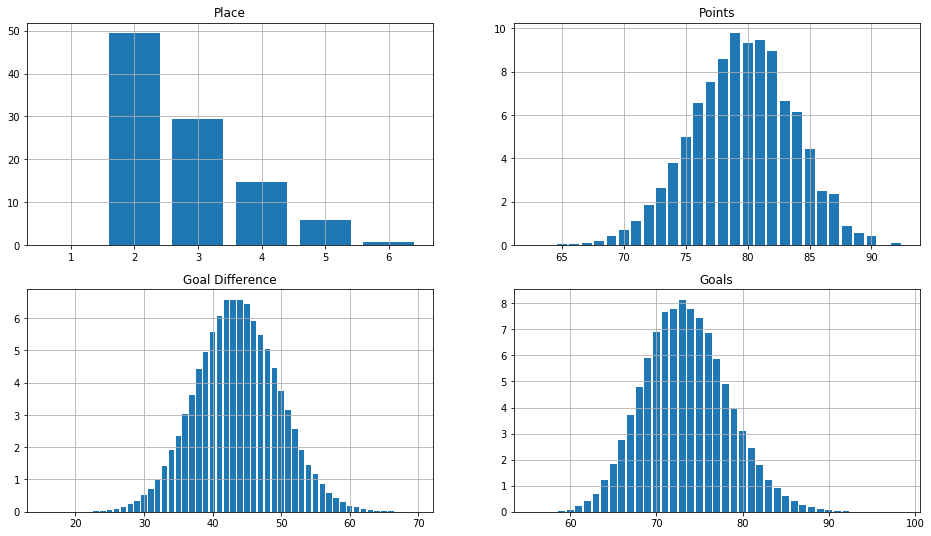

In [8]:
PremierLeague.team_report('Man United')

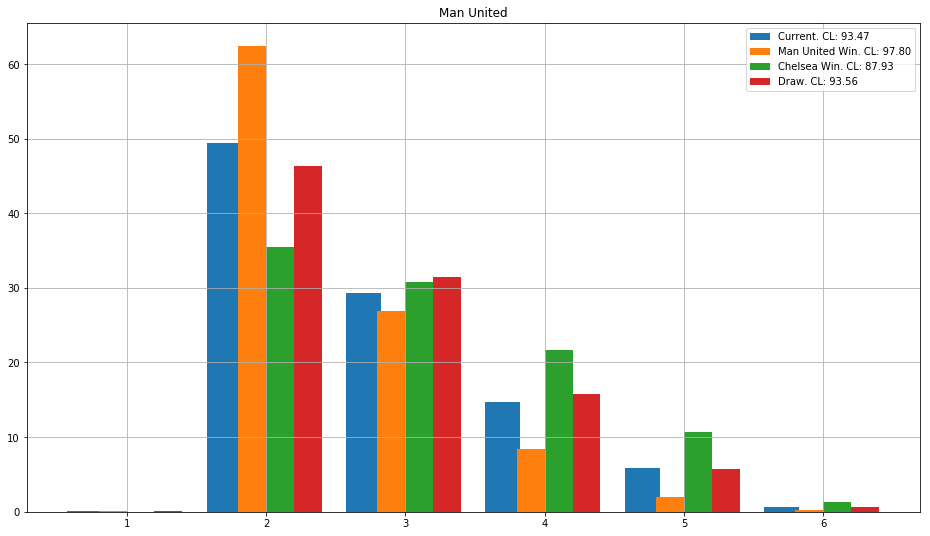

In [9]:
PremierLeague.what_if('Man United v Chelsea',ref_team='Man United')

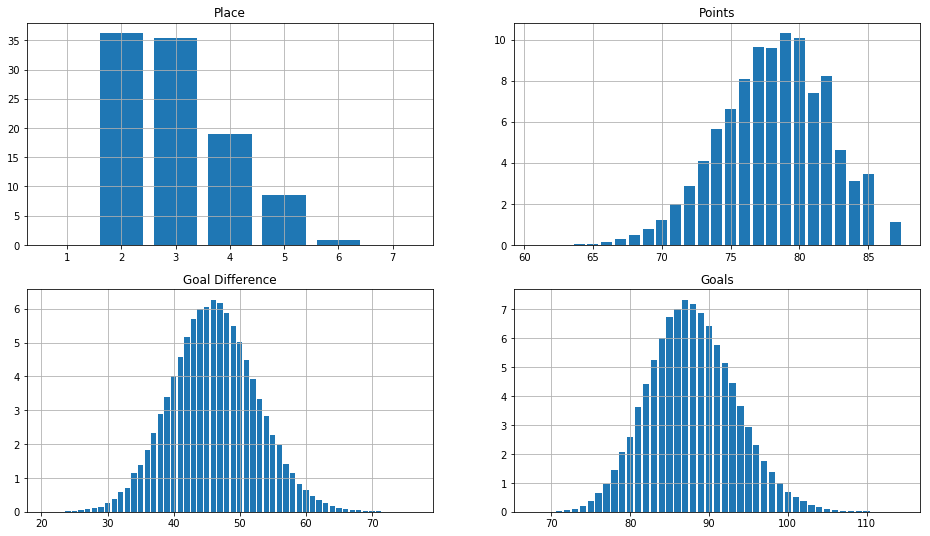

In [10]:
PremierLeague.team_report('Liverpool')

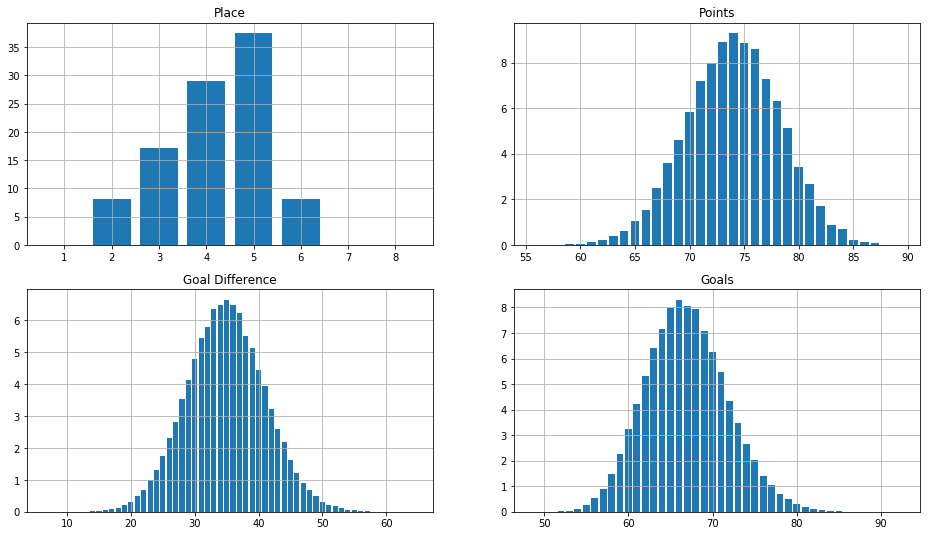

In [11]:
PremierLeague.team_report('Chelsea')

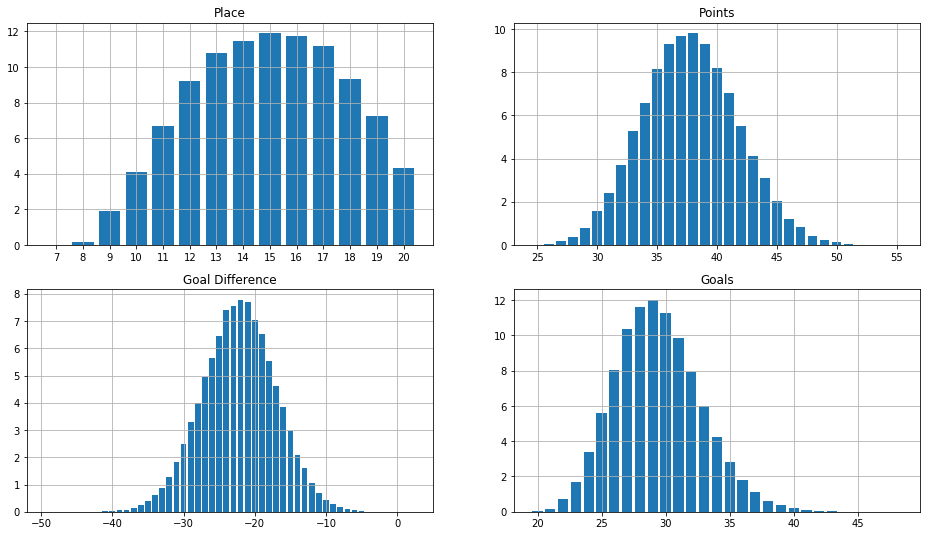

In [12]:
PremierLeague.team_report('Swansea')

In [19]:
GoodTeams={x:teams[x] for x in teams if teams[x].means()[0]>=1 and teams[x].country=='EN'}

In [31]:
GoodLeague=Season(GoodTeams)
GoodLeague.process_current_results(all_data['EN'])
GoodLeague.simulate_season(n_scenarios=100000)
#GoodLeague.process_current_results(all_data['ES'])
#GoodLeague.process_current_results(all_data['DE'])
#GoodLeague.process_current_results(all_data['NL'])
#GoodLeague.process_current_results(all_data['FR'])
#GoodLeague.process_current_results(all_data['IT'])


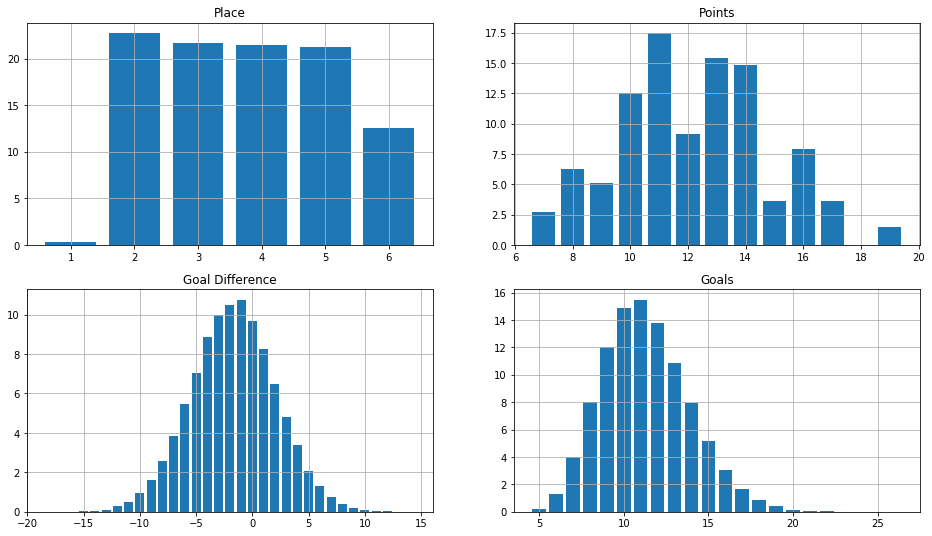

In [33]:
GoodLeague.team_report('Man United')

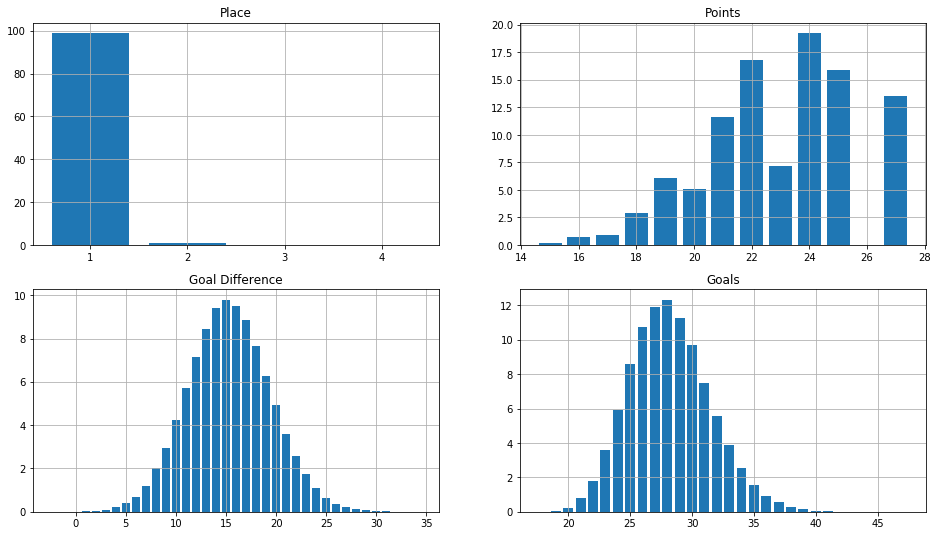

In [34]:
GoodLeague.team_report('Man City')

In [35]:
GoodLeague.season_report()

,Points (mean),Points (low),Points (high),Win,CL,Off,Deff,Degr
Man City,23.0,18.0,27.0,98.85,100.00,2.27,0.19,0.00
Chelsea,13.4,9.0,19.0,0.74,78.23,1.13,0.19,41.41
Liverpool,13.2,10.0,16.0,0.02,83.25,1.69,0.28,38.86
Man United,12.2,7.0,17.0,0.36,66.21,1.27,0.14,55.29
Tottenham,11.1,7.0,16.0,0.03,54.33,1.37,0.20,70.94
Arsenal,9.1,6.0,13.0,0.00,17.97,1.35,0.58,93.50


In [24]:
GoodLeague.teams

{'Arsenal': <football_sim.Team at 0x7ff359ddbfd0>,
 'Chelsea': <football_sim.Team at 0x7ff359ddbf28>,
 'Liverpool': <football_sim.Team at 0x7ff390380550>,
 'Man City': <football_sim.Team at 0x7ff359ddbcf8>,
 'Man United': <football_sim.Team at 0x7ff359ddb160>,
 'Tottenham': <football_sim.Team at 0x7ff359ddbd68>}